# Import libraries

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

try:
    import shap
except ModuleNotFoundError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap", "-q"])
    import shap




# Load Telecom Customer Churn Dataset

In [39]:

df = pd.read_csv("Telco-Customer-Churn.csv")
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


# Cleaning: missing values, duplicates, outliers IQR capping

In [40]:
df_clean = df.copy()

if "TotalCharges" in df_clean.columns:
    df_clean["TotalCharges"] = pd.to_numeric(df_clean["TotalCharges"], errors="coerce")
    med_tc = df_clean["TotalCharges"].median()
    df_clean["TotalCharges"] = df_clean["TotalCharges"].fillna(med_tc)

In [41]:

id_like = {"customerID"}  
cat_cols = [c for c in df_clean.columns if df_clean[c].dtype == "object" and c not in id_like]
for c in cat_cols:
    df_clean[c] = df_clean[c].fillna("Unknown")
    df_clean.loc[df_clean[c].astype(str).str.strip() == "", c] = "Unknown"

# Remove exact duplicates

In [42]:
before = len(df_clean)
df_clean = df_clean.drop_duplicates()
duplicates_removed = before - len(df_clean)
print(f"Duplicates removed: {duplicates_removed}")

Duplicates removed: 0


# IQR capping for outliers 

In [43]:



def iqr_caps(s: pd.Series, whisker: float = 1.5):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return q1 - whisker*iqr, q3 + whisker*iqr

numeric_candidates = ["tenure", "MonthlyCharges", "TotalCharges"]
num_cols = [c for c in numeric_candidates if c in df_clean.columns]

In [44]:
for c in num_cols:
    df_clean[c] = pd.to_numeric(df_clean[c], errors="coerce")


df_before_cap = df_clean[num_cols].copy()

cap_bounds = {}
for c in num_cols:
    series = df_clean[c].dropna()
    low, up = iqr_caps(series)
    df_clean[c] = df_clean[c].clip(lower=low, upper=up)
    cap_bounds[c] = (low, up)

print("Clean shape:", df_clean.shape)
df_clean.head()

Clean shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Exploratory Data Analysis (EDA)

This section explores the cleaned dataset to understand data distribution, key relationships, and churn patterns.  



# Customer Churn Distribution

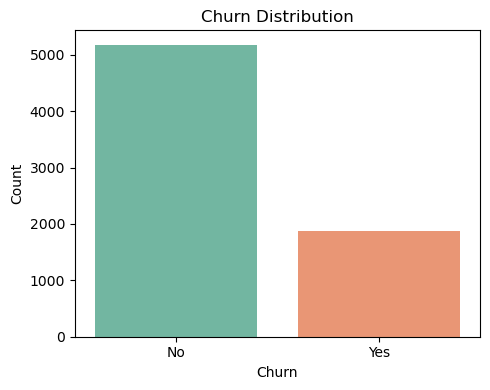

In [45]:
plt.figure(figsize=(5,4))
sns.countplot(x='Churn', data=df_clean, hue='Churn', palette='Set2', legend=False)

plt.title('Churn Distribution')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# Tenure vs Monthly Charges by Churn Status

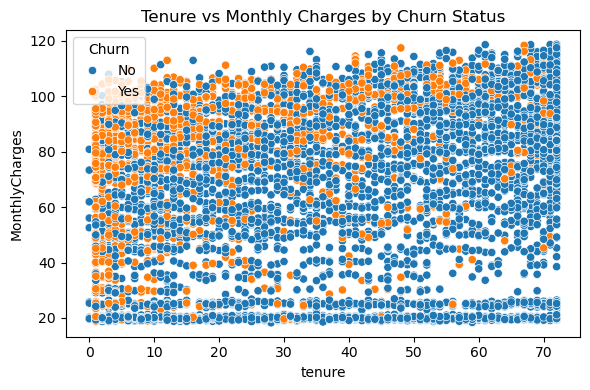

In [46]:
plt.figure(figsize=(6,4))
sns.scatterplot(x='tenure', y='MonthlyCharges', hue='Churn', data=df_clean)
plt.title('Tenure vs Monthly Charges by Churn Status')
plt.tight_layout()
plt.show()


# Churn by Contract Type

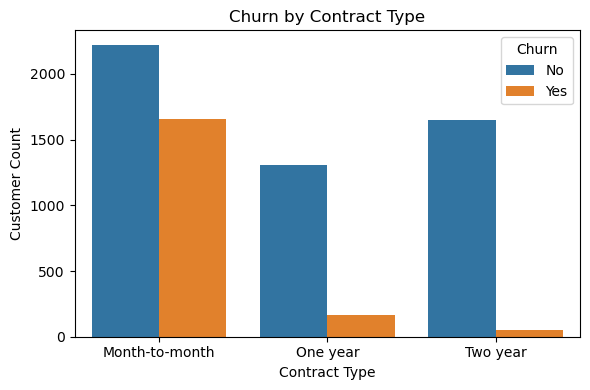

In [47]:
plt.figure(figsize=(6,4))
sns.countplot(x='Contract', hue='Churn', data=df_clean)
plt.title('Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Customer Count')
plt.tight_layout()
plt.show()


# Monthly Charges by Internet Service Type

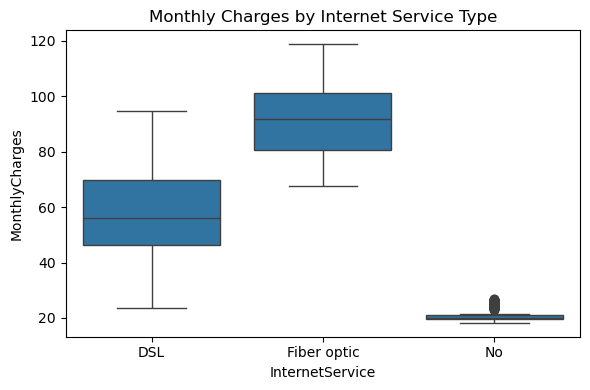

In [48]:
plt.figure(figsize=(6,4))
sns.boxplot(x='InternetService', y='MonthlyCharges', data=df_clean)
plt.title('Monthly Charges by Internet Service Type')
plt.tight_layout()
plt.show()


# Correlation Heatmap — Numeric Features

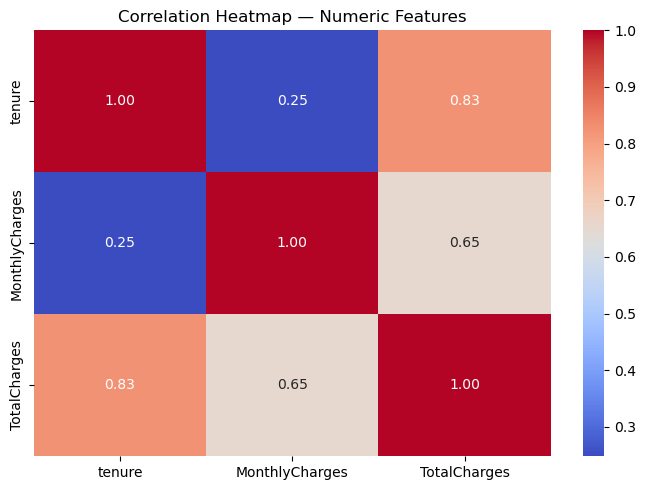

In [49]:
plt.figure(figsize=(7,5))
sns.heatmap(df_clean[['tenure','MonthlyCharges','TotalCharges']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap — Numeric Features')
plt.tight_layout()
plt.show()


# Pairwise Relationships Between Key Variables

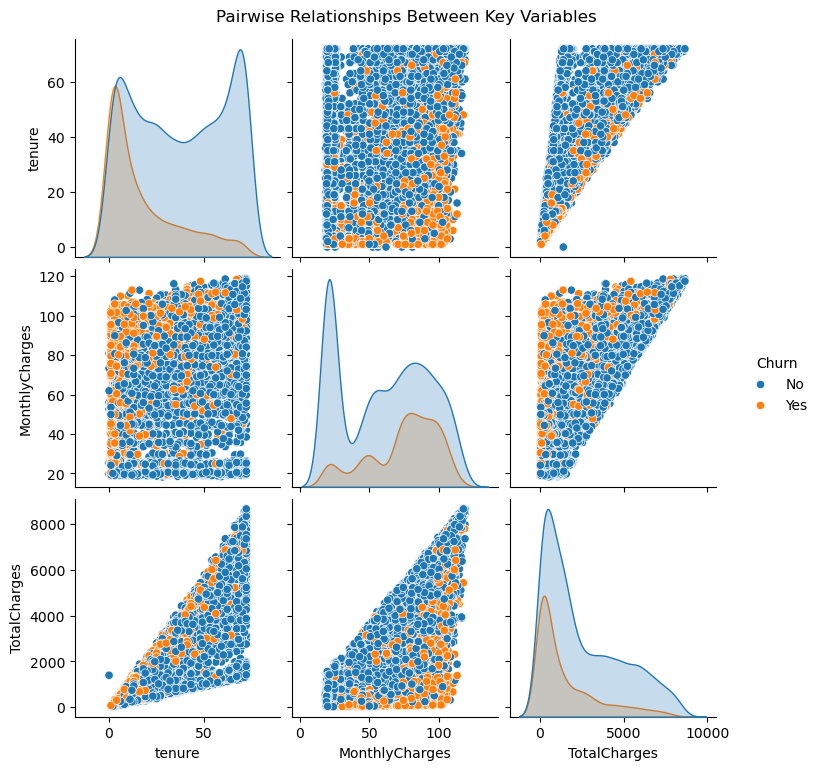

In [50]:
sns.pairplot(df_clean[['tenure','MonthlyCharges','TotalCharges','Churn']], hue='Churn', diag_kind='kde')
plt.suptitle('Pairwise Relationships Between Key Variables', y=1.02)
plt.show()


# EDA Summary
- **Churn Distribution:** The dataset is imbalanced, with fewer churned customers.
- **Tenure vs MonthlyCharges:** Customers with shorter tenure and higher charges tend to churn more.
- **Contract Type:** Month-to-month contracts show the highest churn rates.
- **Internet Service:** Fiber-optic users pay higher charges and churn more frequently.
- **Heatmap:** Monthly and total charges are highly correlated; tenure has moderate correlation with both.

# After Cleaning 

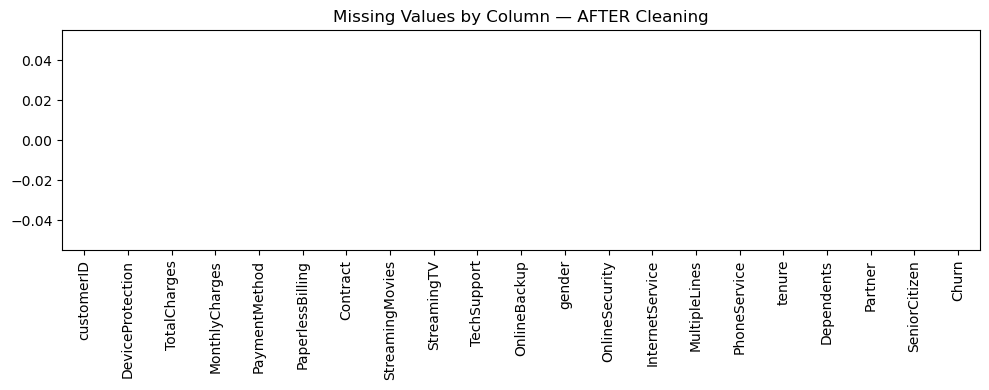

In [51]:

plt.figure(figsize=(10,4))
df_clean.isna().sum().sort_values(ascending=False).plot(kind="bar")
plt.title("Missing Values by Column — AFTER Cleaning")
plt.tight_layout()
plt.show()


# TotalCharges Imputation Check 

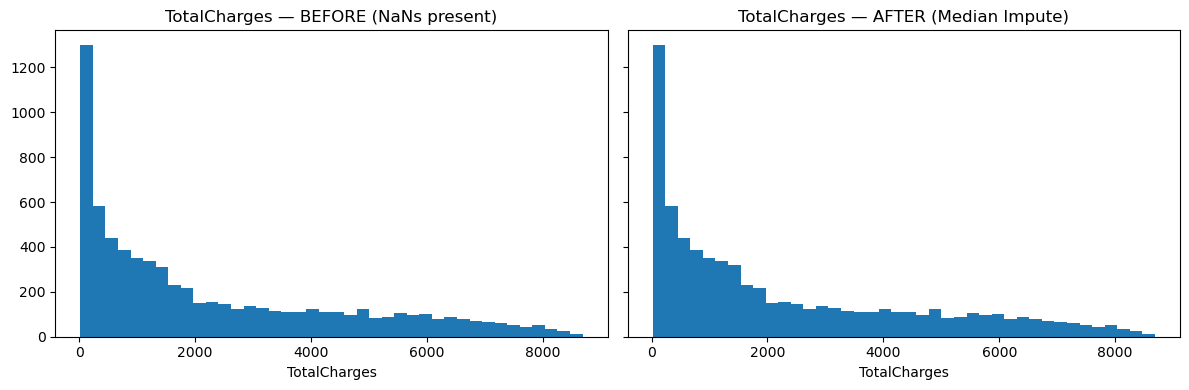

In [52]:

if "TotalCharges" in df.columns:
    before_vals = pd.to_numeric(df["TotalCharges"], errors="coerce")
    after_vals  = pd.to_numeric(df_clean["TotalCharges"], errors="coerce")

    fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
    axes[0].hist(before_vals.dropna(), bins=40)
    axes[0].set_title("TotalCharges — BEFORE (NaNs present)")
    axes[0].set_xlabel("TotalCharges")

    axes[1].hist(after_vals.dropna(), bins=40)
    axes[1].set_title("TotalCharges — AFTER (Median Impute)")
    axes[1].set_xlabel("TotalCharges")

    plt.tight_layout()
    plt.show()

# Boxplots with IQR caps for each numeric column

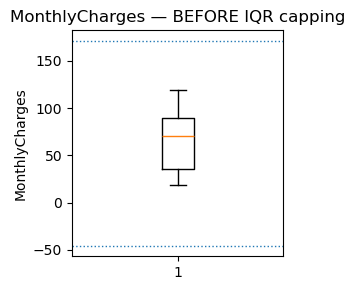

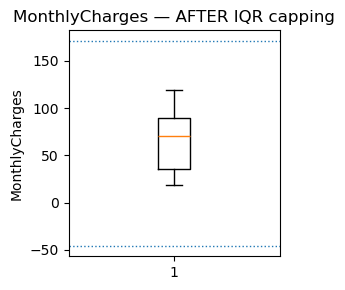

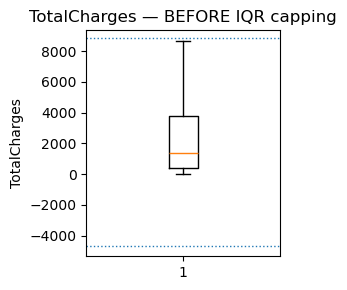

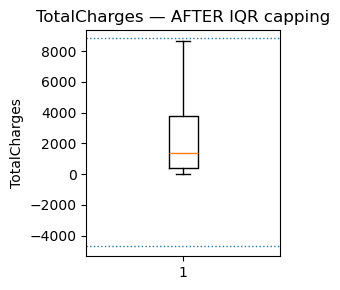

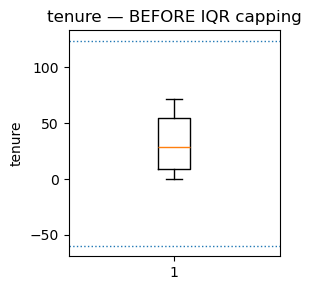

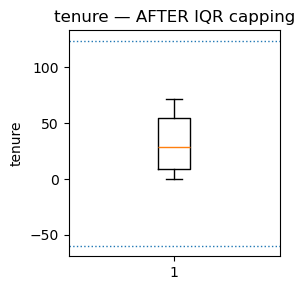

In [53]:


for c in [col for col in ["MonthlyCharges","TotalCharges","tenure"] if col in df_clean.columns]:
    low, up = cap_bounds.get(c, (None, None))
    
    plt.figure(figsize=(3,3))
    plt.boxplot(df_before_cap[c].dropna(), vert=True)
    if low is not None: plt.axhline(low, linestyle=":", linewidth=1)
    if up  is not None: plt.axhline(up,  linestyle=":", linewidth=1)
    plt.title(f"{c} — BEFORE IQR capping")
    plt.ylabel(c)
    plt.tight_layout()
    plt.show()

  
    plt.figure(figsize=(3,3))
    plt.boxplot(df_clean[c].dropna(), vert=True)
    if low is not None: plt.axhline(low, linestyle=":", linewidth=1)
    if up  is not None: plt.axhline(up,  linestyle=":", linewidth=1)
    plt.title(f"{c} — AFTER IQR capping")
    plt.ylabel(c)
    plt.tight_layout()
    plt.show()

# Churn Distribution and Count

In [54]:
print("Churn Distribution")
churn_dist = df["Churn"].value_counts(normalize=True).reset_index()
churn_dist.columns = ["Churn", "Proportion"]
print(churn_dist.to_string(index=False))
churn_counts = df["Churn"].value_counts().reset_index()
churn_counts.columns = ["Churn", "Count"]
print("Churn Counts")
print(churn_counts.to_string(index=False))




Churn Distribution
Churn  Proportion
   No     0.73463
  Yes     0.26537
Churn Counts
Churn  Count
   No   5174
  Yes   1869


#  Churn Balance Plot

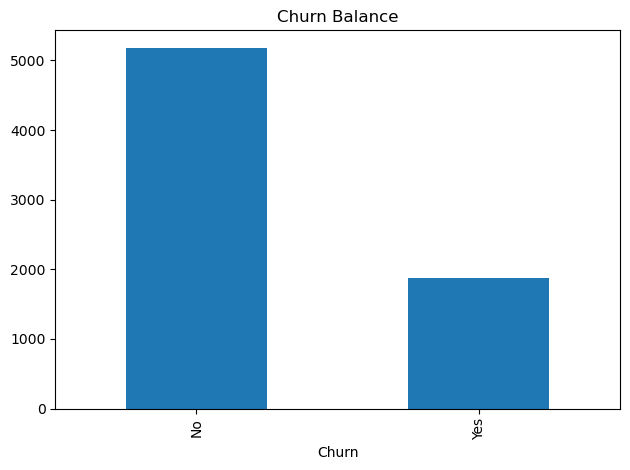

In [55]:

df["Churn"].value_counts().plot(kind="bar", title="Churn Balance")
plt.tight_layout(); plt.show()


# Numeric Summary

In [56]:

print("\n=== Numeric Summary ===")
print(df.describe())




=== Numeric Summary ===
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


# Churn Rate by Key Categorical Features

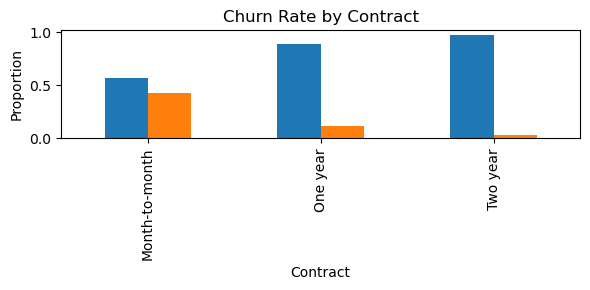

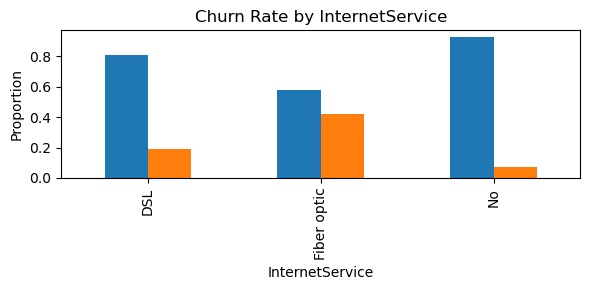

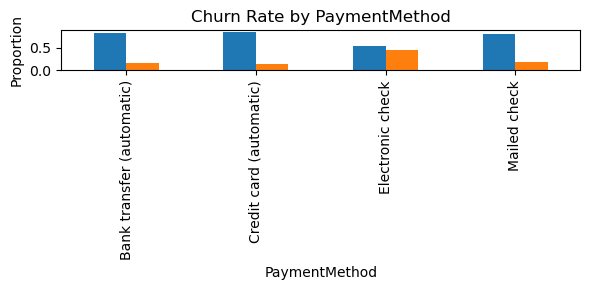

In [57]:

categorical_cols = ["Contract", "InternetService", "PaymentMethod"]
for col in categorical_cols:
    if col in df.columns:
        churn_rate = pd.crosstab(df[col], df["Churn"], normalize="index")
        ax = churn_rate.plot(kind="bar", figsize=(6,3), title=f"Churn Rate by {col}", legend=False)
        plt.ylabel("Proportion")
        plt.tight_layout()
        plt.show()

# Model Training and Evaluation
The next section applies regression models to predict customer churn probability and evaluates their performance.


#  Train/Test Split, Preprocessing, and Evaluation Setup

In [58]:

X = df.drop(columns=[c for c in ["Churn", "customerID"] if c in df.columns]).copy()
y = (df["Churn"].astype(str).str.strip().str.lower().isin(["yes", "1", "true"])).astype(int)


def make_ohe():
    try:
        
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), selector(dtype_include="number")),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("ohe", make_ohe()),
        ]), selector(dtype_exclude="number")),
    ],
    remainder="drop"
)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


def evaluate(clf, name, X_test, y_test):
    pred = clf.predict(X_test)
    proba = getattr(clf, "predict_proba", None)
    prob1 = proba(X_test)[:, 1] if proba is not None else pred  # fall back if needed

    print(f" Metrics ")
    print("Accuracy :", round(accuracy_score(y_test, pred), 4))
    print("Precision:", round(precision_score(y_test, pred), 4))
    print("Recall   :", round(recall_score(y_test, pred), 4))
    print("F1-score :", round(f1_score(y_test, pred), 4))
    try:
        print("AUC      :", round(roc_auc_score(y_test, prob1), 4))
    except Exception:
        pass




# Random Forest

In [59]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
       
    )),
])

rf_clf.fit(X_train, y_train)
evaluate(rf_clf, "Random Forest", X_test, y_test)

 Metrics 
Accuracy : 0.7864
Precision: 0.629
Recall   : 0.4759
F1-score : 0.5419
AUC      : 0.8205


# Random Forest Feature Importance

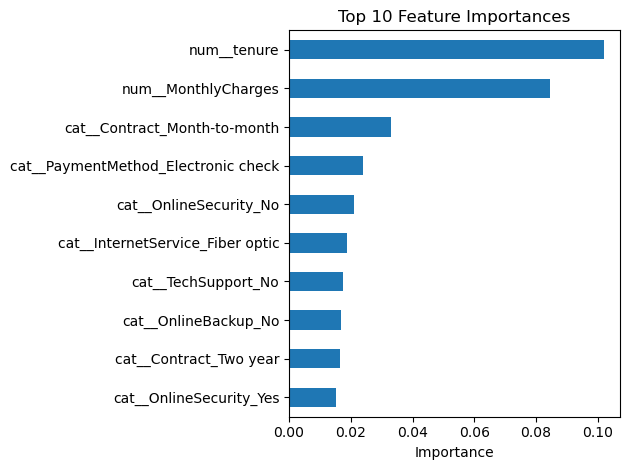

In [60]:
try:
    prep = rf_clf.named_steps["prep"]
    feat_names = prep.get_feature_names_out()
    importances = rf_clf.named_steps["clf"].feature_importances_
    imp = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(10)
    ax = imp.iloc[::-1].plot(kind="barh", title="Top 10 Feature Importances")
    ax.set_xlabel("Importance")
    plt.tight_layout(); plt.show()
except Exception:
    pass

# XGBoost

In [61]:


xgb_clf = Pipeline([
    ("prep", preprocessor),
    ("clf", xgb.XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    )),
])

xgb_clf.fit(X_train, y_train)
evaluate(xgb_clf, "XGBoost", X_test, y_test)

 Metrics 
Accuracy : 0.7807
Precision: 0.6
Recall   : 0.5214
F1-score : 0.5579
AUC      : 0.826



# Feature importances for XGBoost


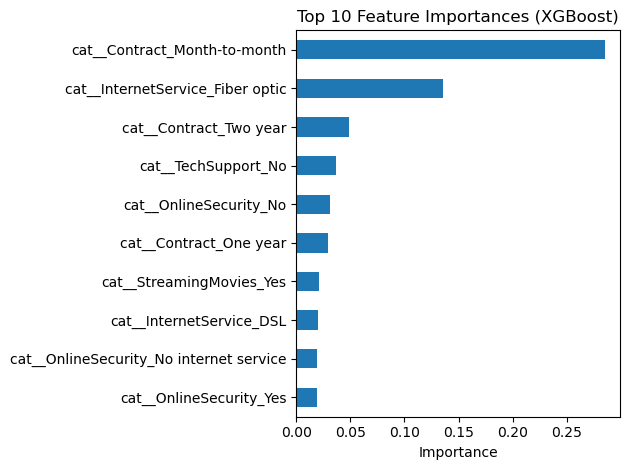

In [62]:

try:
    prep = xgb_clf.named_steps["prep"]
    feat_names = prep.get_feature_names_out()

    clf = xgb_clf.named_steps["clf"]
    importances = clf.feature_importances_

    imp = pd.Series(importances, index=feat_names).sort_values(ascending=False).head(10)
    ax = imp.iloc[::-1].plot(kind="barh", title="Top 10 Feature Importances (XGBoost)")
    ax.set_xlabel("Importance")
    plt.tight_layout(); plt.show()
except Exception as e:
    print("Could not extract feature importances:", e)


# Build an EBM-specific preprocessor: numeric impute, categorical passthrough

In [63]:

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]


for c in cat_cols:
    X_train[c] = X_train[c].astype("category")
    X_test[c]  = X_test[c].astype("category")

preprocessor_ebm = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
        ]), num_cols),
        ("cat", "passthrough", cat_cols),
    ],
    remainder="drop",
)


# EBM :  Train, Evaluate & Explain

In [64]:
from interpret.glassbox import ExplainableBoostingClassifier
from sklearn.pipeline import Pipeline

ebm_clf = Pipeline([
    ("prep", preprocessor_ebm),
    ("clf", ExplainableBoostingClassifier(
        interactions=10,        
        max_bins=256,           
        max_leaves=3,           
        min_samples_leaf=10,    
        outer_bags=16,          
        learning_rate=0.02,     
        early_stopping_rounds=100,
        validation_size=0.15,
        n_jobs=-1,
        random_state=42,
    )),
])


In [65]:
ebm_clf.fit(X_train, y_train)
evaluate(ebm_clf, "EBM ", X_test, y_test)


 Metrics 
Accuracy : 0.8027
Precision: 0.6622
Recall   : 0.5241
F1-score : 0.5851
AUC      : 0.8454


# Confusion Matrices for all models

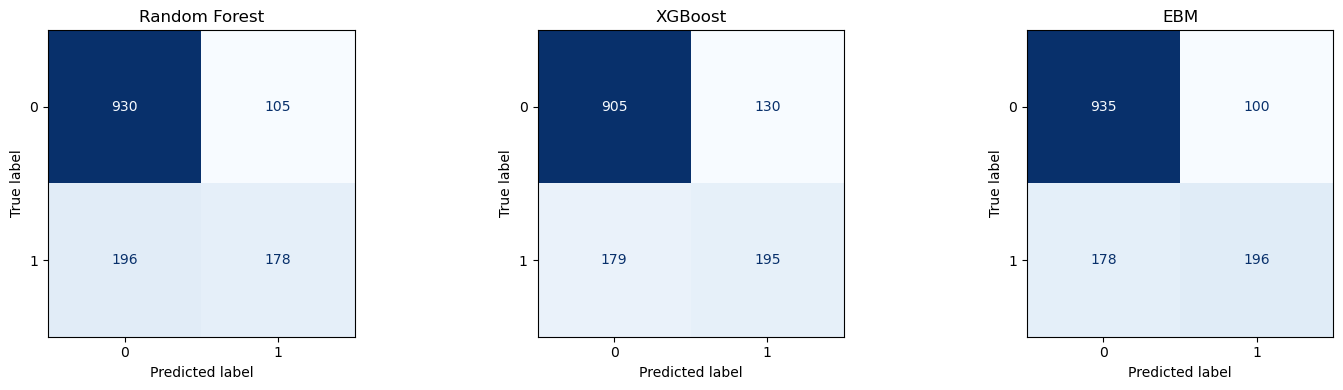

In [66]:

models = {
    "Random Forest": rf_clf,
    "XGBoost": xgb_clf,
    "EBM": ebm_clf,
}

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, clf) in zip(axes, models.items()):
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
    ax.set_title(name)

plt.tight_layout()
plt.show()

# ROC Curve and Comparative Table

               Accuracy  Precision  Recall      F1     AUC
Model                                                     
EBM              0.8027     0.6622  0.5241  0.5851  0.8454
XGBoost          0.7807     0.6000  0.5214  0.5579  0.8260
Random Forest    0.7864     0.6290  0.4759  0.5419  0.8205


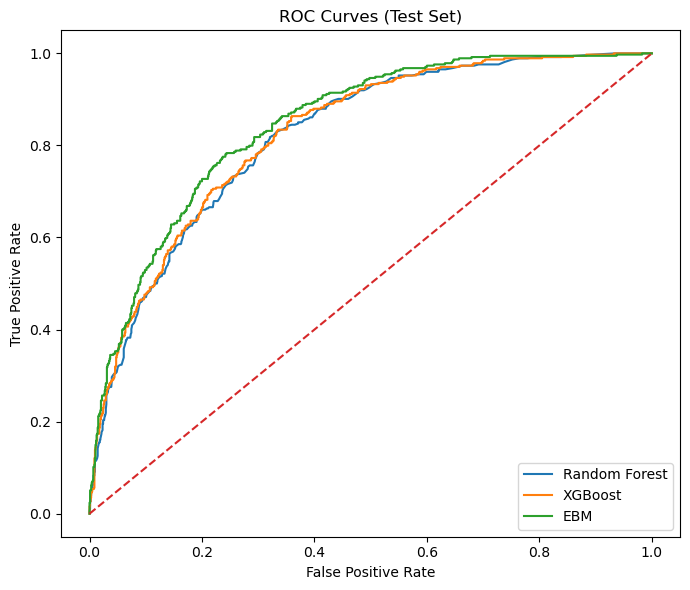

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
)

def pos_score(model, X):
    """Positive-class score: predict_proba→decision_function→predict."""
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X)
        return p[:, 1] if p.ndim == 2 else np.ravel(p)
    if hasattr(model, "decision_function"):
        return np.ravel(model.decision_function(X))  # raw scores are fine for ROC
    return np.ravel(model.predict(X)).astype(float)

def evaluate(model, X, y):
    y_pred  = model.predict(X)
    y_score = pos_score(model, X)

    metrics = {
        "Accuracy":  accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred, zero_division=0),
        "Recall":    recall_score(y, y_pred, zero_division=0),
        "F1":        f1_score(y, y_pred, zero_division=0),
    }
  
    try:
        metrics["AUC"] = roc_auc_score(y, y_score)
        fpr, tpr, _    = roc_curve(y, y_score)
    except Exception:
        metrics["AUC"] = np.nan
        fpr, tpr = np.array([0, 1]), np.array([0, 1])

    return metrics, (fpr, tpr)


rows, roc_curves = [], {}
for name, model in models.items():
    m, (fpr, tpr) = evaluate(model, X_test, y_test)
    rows.append({"Model": name, **m})
    roc_curves[name] = (fpr, tpr)

comp_df = (
    pd.DataFrame(rows)
      .set_index("Model")
      .sort_values("AUC", ascending=False)
      .round(4)
)


try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("Comparative Metrics (Test Set)", comp_df)
except Exception:
    print(comp_df)


plt.figure(figsize=(7, 6))
for name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=name)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Set)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


# Hyperparameter Sensitivity

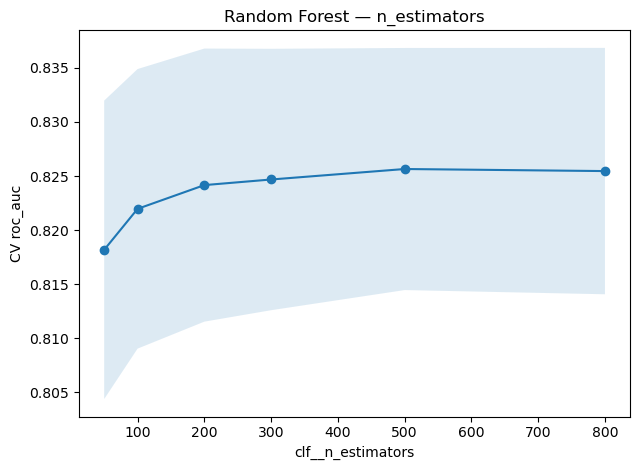

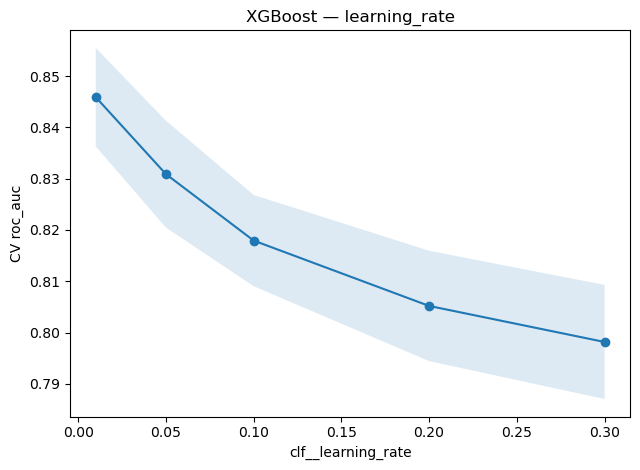

In [69]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import cross_val_score
def sweep_param(model, X, y, param, values, scoring="roc_auc", cv=5, rs=42, title=None):
    """Cross-validated sensitivity sweep for one hyperparameter."""
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=rs)

    rows = []
    for v in values:
        m = clone(model)
        try:
            m.set_params(**{param: v})
        except ValueError as e:
            raise ValueError(
                f"Param '{param}' not found. If using a Pipeline, prefix with the step name (e.g., 'clf__...').\n{e}"
            )
        scores = cross_val_score(m, X, y, scoring=scoring, cv=skf, n_jobs=-1)
        rows.append({param: v, "mean": scores.mean(), "std": scores.std(ddof=1) if len(scores) > 1 else 0.0})

    df = pd.DataFrame(rows)

 
    xs = df[param].values
    ys = df["mean"].values
    es = df["std"].values

    plt.figure(figsize=(6.5, 4.8))
    plt.plot(xs, ys, marker="o")
    try:
        plt.fill_between(xs, ys - es, ys + es, alpha=0.15)
    except Exception:
      
        pass
    plt.xlabel(param)
    plt.ylabel(f"CV {scoring}")
    plt.title(title or f"Sensitivity: {param}")
    plt.tight_layout()
    plt.show()

    return df.sort_values("mean", ascending=False).reset_index(drop=True)


rf_n_results  = sweep_param(
    rf_clf, X_train, y_train,
    param="clf__n_estimators",
    values=[50, 100, 200, 300, 500, 800],
    scoring="roc_auc",
    title="Random Forest — n_estimators"
)

xgb_lr_results = sweep_param(
    xgb_clf, X_train, y_train,
    param="clf__learning_rate",
    values=[0.01, 0.05, 0.1, 0.2, 0.3],
    scoring="roc_auc",
    title="XGBoost — learning_rate"
)



# SHAP Setup — Data Transformation and Feature Extraction

In [74]:


shap.initjs()
prep = preprocessor
X_train_t = prep.transform(X_train)
X_test_t = prep.transform(X_test)
try:
    feat_names = prep.get_feature_names_out()
except Exception:
    feat_names = np.array([f"feature_{i}" for i in range(X_test_t.shape[1])])



# RANDOM FOREST SHAP 


🔹 Calculating Random Forest SHAP values...


100%|===================| 2816/2818 [25:50<00:01]        

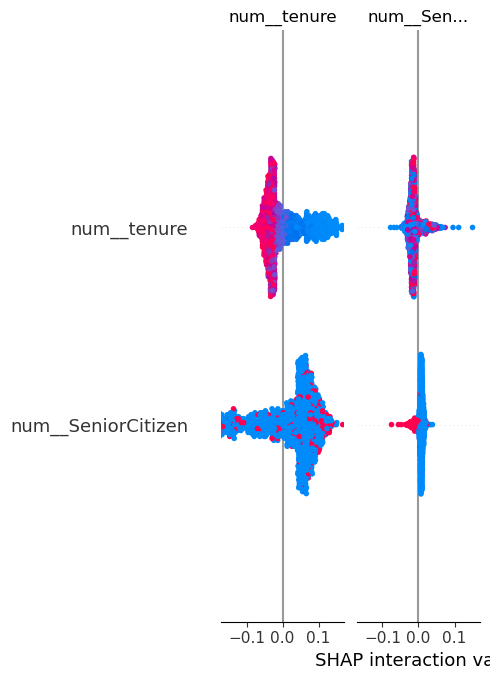

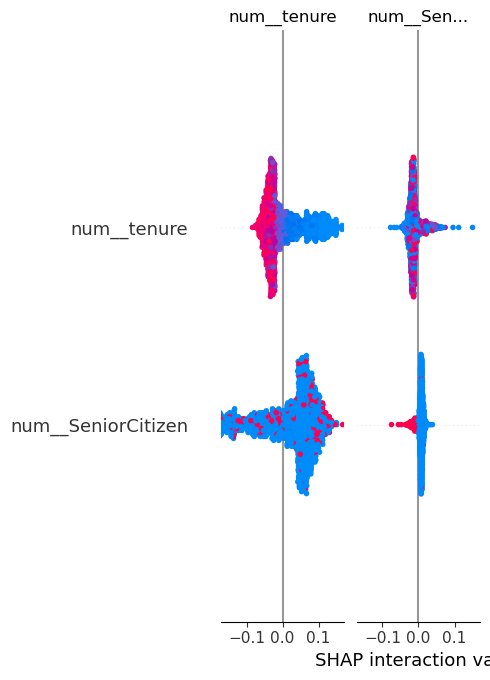

In [75]:

try:
    print("\n🔹 Calculating Random Forest SHAP values...")
    rf_model = rf_clf.named_steps["clf"]

        rf_explainer = shap.TreeExplainer(
        rf_model,
        data=X_train_t,
        feature_perturbation="interventional"
    )

    rf_shap = rf_explainer.shap_values(X_test_t, check_additivity=False)


    if isinstance(rf_shap, list) and len(rf_shap) >= 2:
        rf_shap_to_plot = rf_shap[1]
    else:
        rf_shap_to_plot = rf_shap

    shap.summary_plot(rf_shap_to_plot, X_test_t, feature_names=feat_names, plot_type="bar", show=True)
    shap.summary_plot(rf_shap_to_plot, X_test_t, feature_names=feat_names, show=True)

except Exception as e:
    print(f" RF SHAP failed: {e}")



# XGBOOST SHAP


🔹 Calculating XGBoost SHAP values...


 99%|===================| 1393/1409 [00:49<00:00]        

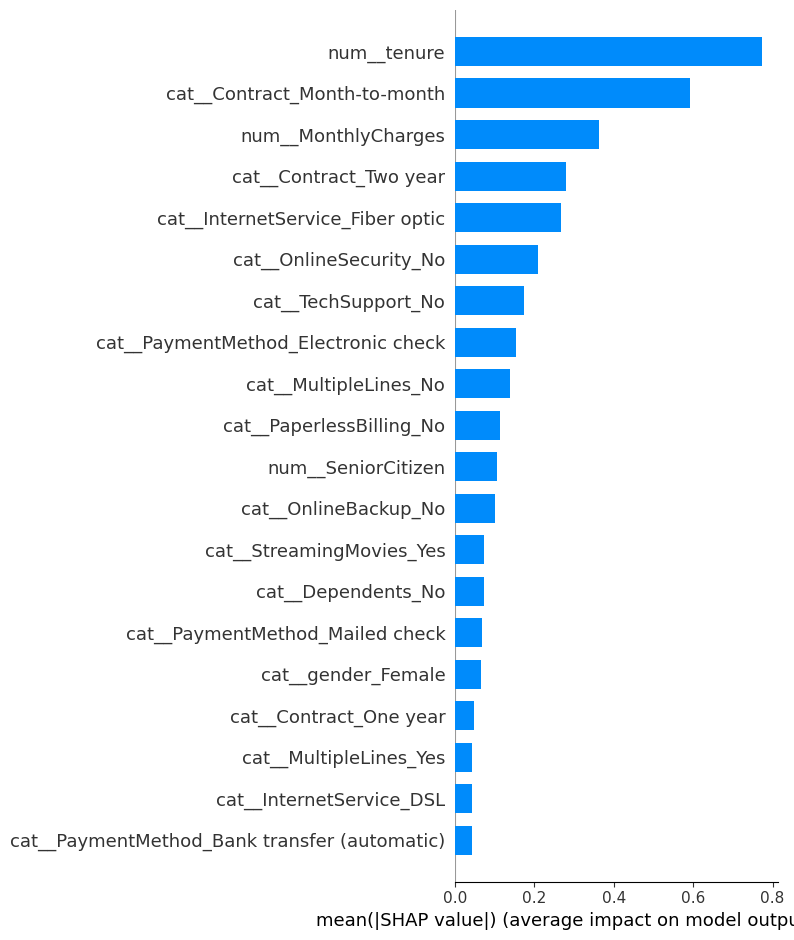

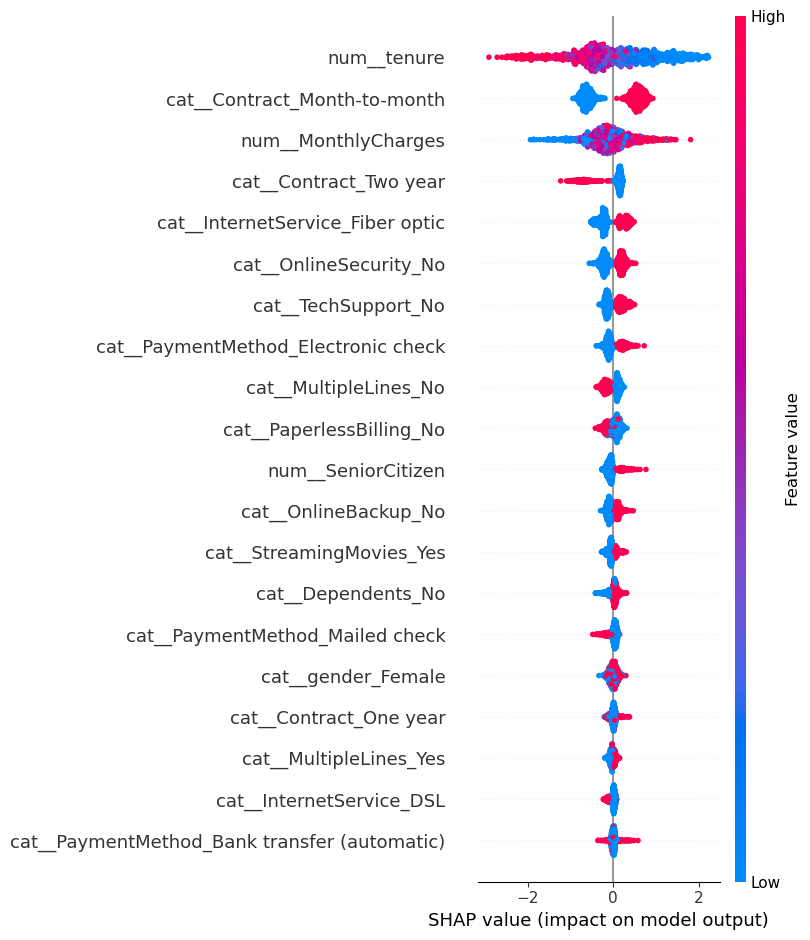

In [77]:
try:
    print("\n🔹 Calculating XGBoost SHAP values...")
    xgb_model = xgb_clf.named_steps["clf"]  


    xgb_explainer = shap.TreeExplainer(
        xgb_model,
        data=X_train_t,
        feature_perturbation="interventional"
    )

  
    xgb_shap = xgb_explainer.shap_values(X_test_t, check_additivity=False)


    if isinstance(xgb_shap, list) and len(xgb_shap) >= 2:
        xgb_shap_to_plot = xgb_shap[1]
    else:
        xgb_shap_to_plot = xgb_shap

    shap.summary_plot(xgb_shap_to_plot, X_test_t, feature_names=feat_names,
                      plot_type="bar", show=True)

    
    shap.summary_plot(xgb_shap_to_plot, X_test_t, feature_names=feat_names,
                      show=True)

except Exception as e:
    print(f" XGBoost SHAP failed: {e}")

# EBM Global Explanation


🔹 Generating EBM Global Explanation...


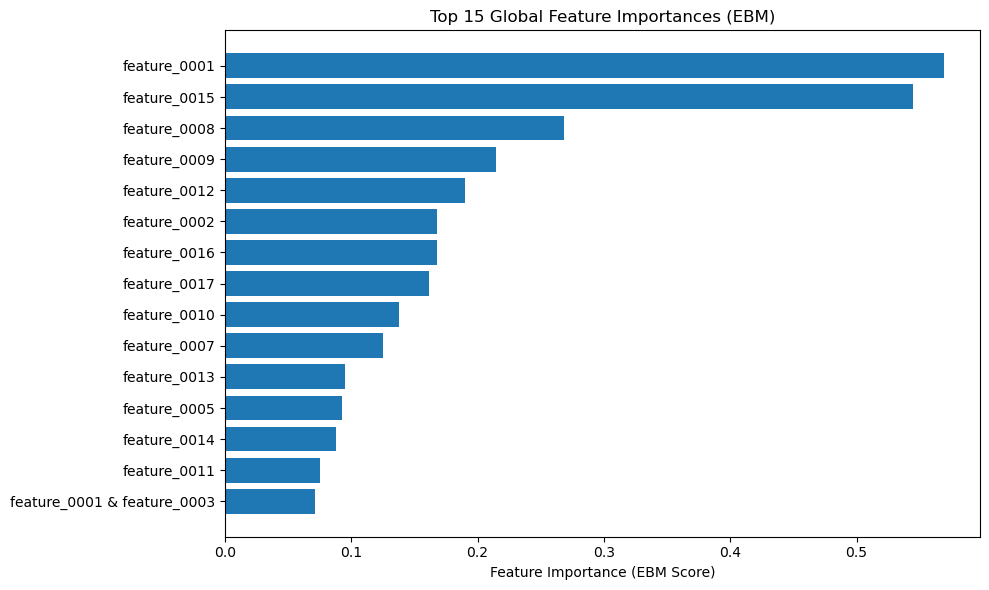

✅ Saved: ebm_global_importance.png


In [78]:
ebm_model = ebm_clf.named_steps["clf"] 

try:
    print("\n🔹 Generating EBM Global Explanation...")
    ebm_global = ebm_model.explain_global(name="EBM Global Explanation")

except Exception as e:
    print(f"EBM Global Explanation failed: {e}")


try:
    global_data = ebm_global.data()
    feature_names = np.array(global_data["names"])
    importances = np.array(global_data["scores"])

    sorted_idx = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.barh(feature_names[sorted_idx][:15], importances[sorted_idx][:15])
    plt.gca().invert_yaxis()
    plt.xlabel("Feature Importance (EBM Score)")
    plt.title("Top 15 Global Feature Importances (EBM)")
    plt.tight_layout()
    plt.savefig("ebm_global_importance.png", dpi=300)
    plt.show()


except Exception as e:
    print(f" Could not save EBM global plot: {e}")

# Counterfactual (What-If) Analysis — Exploring Feature Impact on Churn Probability

In [79]:
def score(model, X):
    """Return predicted scores (probabilities or decision function)."""
    if hasattr(model, "predict_proba"):
        return model.predict_proba(X)[:, 1]
    if hasattr(model, "decision_function"):
        return np.ravel(model.decision_function(X))
    return np.ravel(model.predict(X)).astype(float)


def what_if(model, df, idx, threshold=0.5, **changes):
    """
    Perform a 'what-if' analysis for a single record.
    Safely modifies numeric/categorical features and compares probability change.
    """
  
    row = df.iloc[[idx]].copy()

    before = float(score(model, row)[0])
    for k, v in changes.items():
        if k not in row.columns:
            raise KeyError(f"Feature '{k}' not in data. Available: {list(df.columns)}")
        row[k] = v

    after = float(score(model, row)[0])
    flipped_down = (before >= threshold) and (after < threshold)

    print(f"idx={idx}  changes={changes}  prob: {before:.3f} -> {after:.3f}  flipped_down? {flipped_down}")
    return {"base_prob": before, "new_prob": after, "flipped_down": flipped_down}



model = xgb_clf  
thr = 0.5

X_test = X_test.reset_index(drop=True)


probs = score(model, X_test)


churn_idx = np.where(probs >= thr)[0]
if len(churn_idx) == 0:
    churn_idx = np.argsort(probs)[-5:]
    print("No probs >= 0.5; using top-5 highest-risk customers.")

for i in churn_idx:
    print(f"idx={i}  prob={probs[i]:.3f}")

# Pick one to test
i = int(churn_idx[0])
print("\nUsing idx:", i, "with prob:", probs[i])


for d in (-5, -10, -15, -20):
    what_if(model, X_test, i, threshold=thr,
            MonthlyCharges=X_test.iloc[i]["MonthlyCharges"] + d)


for d in (1, 3, 6):
    what_if(model, X_test, i, threshold=thr,
            tenure=X_test.iloc[i]["tenure"] + d)


for v in ("Month-to-month", "One year", "Two year"):
    what_if(model, X_test, i, threshold=thr, Contract=v)


idx=1  prob=0.914
idx=5  prob=0.737
idx=9  prob=0.571
idx=13  prob=0.728
idx=17  prob=0.563
idx=20  prob=0.775
idx=27  prob=0.888
idx=29  prob=0.658
idx=30  prob=0.550
idx=34  prob=0.827
idx=36  prob=0.507
idx=38  prob=0.882
idx=41  prob=0.927
idx=42  prob=0.510
idx=46  prob=0.630
idx=51  prob=0.924
idx=55  prob=0.541
idx=65  prob=0.563
idx=69  prob=0.833
idx=72  prob=0.506
idx=77  prob=0.518
idx=83  prob=0.873
idx=86  prob=0.819
idx=87  prob=0.739
idx=90  prob=0.559
idx=93  prob=0.576
idx=98  prob=0.880
idx=100  prob=0.818
idx=111  prob=0.709
idx=113  prob=0.502
idx=114  prob=0.674
idx=116  prob=0.663
idx=121  prob=0.901
idx=124  prob=0.724
idx=132  prob=0.590
idx=139  prob=0.612
idx=151  prob=0.596
idx=154  prob=0.889
idx=156  prob=0.587
idx=158  prob=0.568
idx=159  prob=0.534
idx=171  prob=0.932
idx=174  prob=0.600
idx=178  prob=0.510
idx=182  prob=0.789
idx=192  prob=0.548
idx=195  prob=0.569
idx=196  prob=0.586
idx=208  prob=0.607
idx=211  prob=0.607
idx=215  prob=0.553
idx=218  p